In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

import os, glob, inspect, sys


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

### Import Data

In [2]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_simulated.csv'), 
                 index_col=0)
df.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,A,B,p,Absorption_avg_100,Absorption_avg_200,mean_CF,mean_perm,mean_MBN
Condition,,,,,,,,,,,,
T_B1,12.887224,0.000252,0.020317,0.001931,1.202073e-07,0.001092,0.221759,0.000886,0.000301,1.087656,68.832934,0.453917
T_B1,12.904167,0.000194,0.011580,0.001121,2.614525e-08,0.000801,0.214616,0.000605,0.000316,1.094037,67.753088,0.435966
T_B1,12.848012,0.000247,0.027738,0.001309,-3.440295e-07,0.000691,0.173157,0.000556,0.000428,1.098203,67.872952,0.539143
T_B1,12.968064,0.000210,0.019859,0.001921,-5.656336e-07,0.000864,0.213791,0.000746,0.000602,1.117724,65.970169,0.301158
T_B1,12.927068,0.000233,0.013641,0.001425,4.191747e-07,0.000408,0.192750,0.000777,0.000419,1.095836,68.614324,0.472276


### Calculating new values

In [3]:
df['AUC_avg'] = mc.findAUC(df, A=df['A'], B=df['B'], p=df['p'], name='AUC_avg')
df.drop(columns=["A","B","p"],inplace=True)

In [4]:
df['CF_perm'] = df['mean_CF']/df['mean_perm'].astype('float64')
df.drop(columns=["mean_MBN","mean_perm","mean_CF"],inplace=True)

### Scaling Values

In [5]:
scaled_df = mc.scale_general(df, MinMaxScaler())[0]
scaled_df.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,AUC_avg,CF_perm
Condition,,,,,,,,
T_B1,0.867389,0.240323,0.398567,0.371884,0.448386,0.182419,0.299520,0.076871
T_B1,0.873593,0.184685,0.249685,0.264753,0.355158,0.190679,0.257246,0.079202
T_B1,0.853029,0.235852,0.525029,0.289641,0.338891,0.251385,0.209584,0.079423
T_B1,0.896992,0.199505,0.390772,0.370632,0.402020,0.344953,0.242839,0.084560
T_B1,0.881979,0.222254,0.284809,0.304966,0.412269,0.246211,0.213235,0.078013


### Selecting sub samples

In [6]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(scaled_df)

In [7]:
tube.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,AUC_avg,CF_perm
Condition,,,,,,,,
T_B1,0.867389,0.240323,0.398567,0.371884,0.448386,0.182419,0.299520,0.076871
T_B1,0.873593,0.184685,0.249685,0.264753,0.355158,0.190679,0.257246,0.079202
T_B1,0.853029,0.235852,0.525029,0.289641,0.338891,0.251385,0.209584,0.079423
T_B1,0.896992,0.199505,0.390772,0.370632,0.402020,0.344953,0.242839,0.084560
T_B1,0.881979,0.222254,0.284809,0.304966,0.412269,0.246211,0.213235,0.078013


## Clustering

### Elbow Method

In [8]:
min_range = 2
max_range = 8

def plot_elbow_kmeans(feat_norm, title):
    '''
    Elbow plot
    Args:
    - feat_norm : pandas dataframe
    - title : title of the figure ideally correpond to the samples
    return plot
    '''
    
    inertia = []
    k_list = range(min_range, max_range+1)

    for k in k_list:
        km = KMeans(n_clusters = k, random_state= 0)
        km.fit(feat_norm) 
        score = km.inertia_
        inertia.append(score)


    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(min_range , max_range+1) , inertia , 'o')
    plt.plot(np.arange(min_range , max_range+1) , inertia , '-' , alpha = 0.5)

    plt.xlabel('Number of Clusters', fontsize=20) , plt.ylabel('Inertia', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

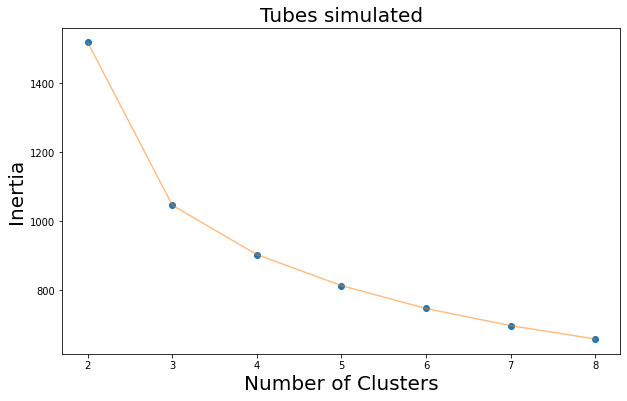

In [11]:
# tubes
plot_elbow_kmeans(tube, title='Tubes simulated')

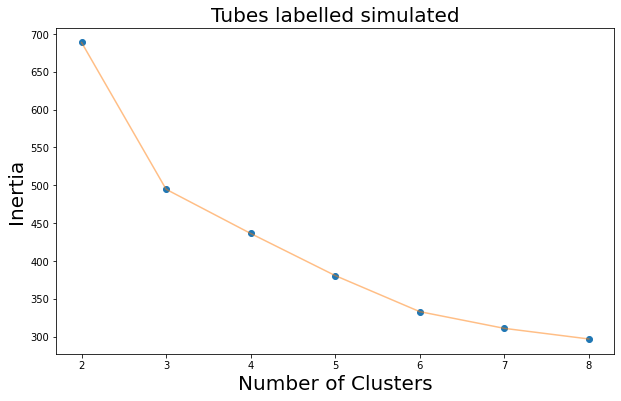

In [12]:
# tubes
plot_elbow_kmeans(tube_wo_blind, title='Tubes labelled simulated')

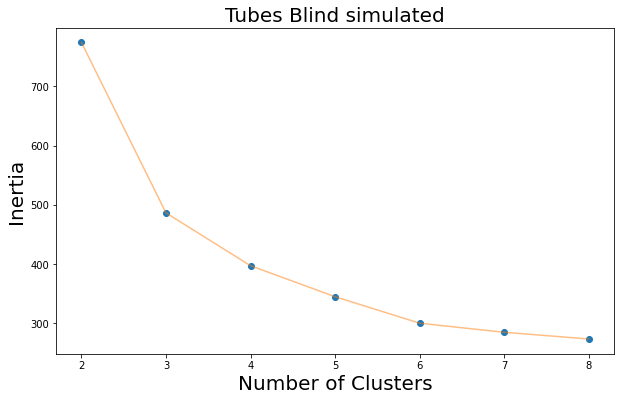

In [13]:
# tubes
plot_elbow_kmeans(tube_blind, title='Tubes Blind simulated')

In [14]:
def calculate_wcss(data):
    '''
    Calculate within class sum-squared value which represents loss in KMeans clustering
    '''
    wcss = []
    for n in range(min_range, max_range):
        kmeans = KMeans(n_clusters=n,random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    return wcss

from math import sqrt

def optimal_number_of_clusters(wcss):
    '''
    Calculate normal distance 
    '''
    x1, y1 = min_range, wcss[0]
    x2, y2 = max_range, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [15]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number of cluster =', n)

Number of cluster = 4


In [16]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube_wo_blind)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number of cluster =', n)

Number of cluster = 3


In [17]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube_blind)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number of cluster =', n)

Number of cluster = 4


In [18]:
from sklearn.metrics.cluster import contingency_matrix
#test wo_blind sample:
model = KMeans(n_clusters=2, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels_2 = model.predict(tube_wo_blind)
silhouette = metrics.silhouette_score(tube_wo_blind, labels_2, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_wo_blind, labels_2)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_wo_blind, labels_2)
print(DB_score)
c_mat=contingency_matrix(tube_wo_blind.index, labels_2)
print(c_mat)
#blind_labels = model.predict(tube_blind)

0.6578618412330764
20051.458708419057
0.5068813733594058
[[1000    0]
 [1000    0]
 [   0 1000]
 [1000    0]
 [   0 1000]
 [1000    0]
 [1000    0]
 [1000    0]]


In [19]:
labeled_df_2 = pd.DataFrame()

In [20]:
labeled_df_2['sample'] = tube_wo_blind.index
labeled_df_2['labels'] = labels_2

In [21]:
labeled_df_2.value_counts()

sample   labels
T_T      0         1000
T_OT     0         1000
T_N_T    0         1000
T_N      1         1000
T_HAZ_T  0         1000
T_HAZ    1         1000
T_FF     0         1000
T_AR     0         1000
dtype: int64

From the contingency matrix and the value counts we can infer that there are 2 clusters grouped as
 - cluster 0 = T_T, T_OT, T_N_T, T_HAZ_T, T_FF, T_AR
 - cluster 1 = T_N, T_HAZ

In [22]:
from sklearn.metrics.cluster import contingency_matrix
#test wo_blind sample:
model = KMeans(n_clusters=3, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels_3 = model.predict(tube_wo_blind)
silhouette = metrics.silhouette_score(tube_wo_blind, labels_3, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_wo_blind, labels_3)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_wo_blind, labels_3)
print(DB_score)
c_mat=contingency_matrix(tube_wo_blind.index, labels_3)
print(c_mat)
#blind_labels = model.predict(tube_blind)

0.4421054214705929
15524.47964871362
0.9830100986588457
[[   0    0 1000]
 [ 990    0   10]
 [   0 1000    0]
 [  33    0  967]
 [   0 1000    0]
 [ 977    0   23]
 [   0    0 1000]
 [   0    0 1000]]


In [23]:
labeled_df_3 = pd.DataFrame()

In [24]:
labeled_df_3['sample'] = tube_wo_blind.index
labeled_df_3['labels'] = labels_3

In [26]:
labeled_df_3.value_counts()

sample   labels
T_T      2         1000
T_OT     2         1000
T_N      1         1000
T_HAZ    1         1000
T_AR     2         1000
T_FF     0          990
T_N_T    0          977
T_HAZ_T  2          967
         0           33
T_N_T    2           23
T_FF     2           10
dtype: int64

From the contingency matrix and the value counts we can infer that there are 3 clusters grouped as

-   cluster 0 = T_N_T, T_FF
-   cluster 1 = T_N, T_HAZ
-   cluster 2 = T_T, T_OT, T_AR, T_HAZ_T

In [27]:
from sklearn.metrics.cluster import contingency_matrix
#test wo_blind sample:
model = KMeans(n_clusters=4, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels_4 = model.predict(tube_wo_blind)
silhouette = metrics.silhouette_score(tube_wo_blind, labels_4, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_wo_blind, labels_4)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_wo_blind, labels_4)
print(DB_score)
c_mat=contingency_matrix(tube_wo_blind.index, labels_4)
print(c_mat)
#blind_labels = model.predict(tube_blind)

0.38343726046177234
12090.781499181037
1.0214629463240974
[[   0    0    0 1000]
 [ 986    0    1   13]
 [   0 1000    0    0]
 [  38    0    6  956]
 [   0 1000    0    0]
 [ 977    0    2   21]
 [   0    0  994    6]
 [   0    0    0 1000]]


In [28]:
labeled_df_4 = pd.DataFrame()

In [29]:
labeled_df_4['sample'] = tube_wo_blind.index
labeled_df_4['labels'] = labels_4

In [30]:
labeled_df_4.value_counts()

sample   labels
T_T      3         1000
T_N      1         1000
T_HAZ    1         1000
T_AR     3         1000
T_OT     2          994
T_FF     0          986
T_N_T    0          977
T_HAZ_T  3          956
         0           38
T_N_T    3           21
T_FF     3           13
T_OT     3            6
T_HAZ_T  2            6
T_N_T    2            2
T_FF     2            1
dtype: int64

From the contingency matrix and the value counts we can infer that there are 4 clusters grouped as

-    cluster 0 = T_FF, T_N_T
-    cluster 1 = T_N, T_HAZ
-    cluster 2 = T_OT
-    cluster 3 = T_T, T_AR, T_HAZ_T

In [31]:
from sklearn.metrics.cluster import contingency_matrix
#test wo_blind sample:
model = KMeans(n_clusters=5, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels_5 = model.predict(tube_wo_blind)
silhouette = metrics.silhouette_score(tube_wo_blind, labels_5, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_wo_blind, labels_5)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_wo_blind, labels_5)
print(DB_score)
c_mat=contingency_matrix(tube_wo_blind.index, labels_5)
print(c_mat)
#blind_labels = model.predict(tube_blind)

0.31633812905460934
10684.533737957347
1.195577163625174
[[   0    0 1000    0    0]
 [ 986    0   13    0    1]
 [   0 1000    0    0    0]
 [  38    0  956    0    6]
 [   0  127    0  873    0]
 [ 977    0   21    0    2]
 [   0    0    6    0  994]
 [   0    0 1000    0    0]]


In [32]:
labeled_df_5 = pd.DataFrame()

In [33]:
labeled_df_5['sample'] = tube_wo_blind.index
labeled_df_5['labels'] = labels_5

In [34]:
labeled_df_5.value_counts()

sample   labels
T_T      2         1000
T_HAZ    1         1000
T_AR     2         1000
T_OT     4          994
T_FF     0          986
T_N_T    0          977
T_HAZ_T  2          956
T_N      3          873
         1          127
T_HAZ_T  0           38
T_N_T    2           21
T_FF     2           13
T_OT     2            6
T_HAZ_T  4            6
T_N_T    4            2
T_FF     4            1
dtype: int64

From the contingency matrix and the value counts we can infer that there are 5 clusters grouped as

-    cluster 0 = T_FF, T_N_T
-    cluster 1 = T_HAZ 
-    cluster 2 = T_AR, T_HAZ_T, T_T
-    cluster 3 = T_N
-    cluster 4 = T_OT

In [35]:
from sklearn.metrics.cluster import contingency_matrix
#test wo_blind sample:
model = KMeans(n_clusters=6, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels_6 = model.predict(tube_wo_blind)
silhouette = metrics.silhouette_score(tube_wo_blind, labels_6, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_wo_blind, labels_6)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_wo_blind, labels_6)
print(DB_score)
c_mat=contingency_matrix(tube_wo_blind.index, labels_6)
print(c_mat)
#blind_labels = model.predict(tube_blind)

0.32042962525260343
9999.314358533578
1.2720140743014048
[[   0 1000    0    0    0    0]
 [ 955   12    0   32    0    1]
 [   0    0 1000    0    0    0]
 [   1  937    0   57    0    5]
 [   0    0  127    0  873    0]
 [  78   11    0  911    0    0]
 [   0    6    0    0    0  994]
 [   0 1000    0    0    0    0]]


In [36]:
labeled_df_6 = pd.DataFrame()

In [37]:
labeled_df_6['sample'] = tube_wo_blind.index
labeled_df_6['labels'] = labels_6

In [38]:
labeled_df_6.value_counts()

sample   labels
T_T      1         1000
T_HAZ    2         1000
T_AR     1         1000
T_OT     5          994
T_FF     0          955
T_HAZ_T  1          937
T_N_T    3          911
T_N      4          873
         2          127
T_N_T    0           78
T_HAZ_T  3           57
T_FF     3           32
         1           12
T_N_T    1           11
T_OT     1            6
T_HAZ_T  5            5
         0            1
T_FF     5            1
dtype: int64

From the contingency matrix and the value counts we can infer that there are 6 clusters grouped as

-    cluster 0 = T_FF
-    cluster 1 = T_AR, T_HAZ_T, T_T
-    cluster 2 = T_HAZ
-    cluster 3 = T_N_T
-    cluster 4 = T_N
-    cluster 5 = T_OT

In [39]:
from sklearn.metrics.cluster import contingency_matrix
#test wo_blind sample:
model = KMeans(n_clusters=7, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels_7 = model.predict(tube_wo_blind)
silhouette = metrics.silhouette_score(tube_wo_blind, labels_7, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_wo_blind, labels_7)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_wo_blind, labels_7)
print(DB_score)
c_mat=contingency_matrix(tube_wo_blind.index, labels_7)
print(c_mat)
#blind_labels = model.predict(tube_blind)

0.2674827615524083
9018.16263690109
1.4365788229945726
[[   0    0  714  286    0    0    0]
 [  31    0    7    9    0  952    1]
 [   0    0    0    0 1000    0    0]
 [  47    0  363  588    0    1    1]
 [   0  874    0    0  126    0    0]
 [ 899    0   16    6    0   79    0]
 [   0    0    5    2    0    0  993]
 [   0    0  365  635    0    0    0]]


In [40]:
labeled_df_7 = pd.DataFrame()

In [41]:
labeled_df_7['sample'] = tube_wo_blind.index
labeled_df_7['labels'] = labels_7

In [42]:
labeled_df_7.value_counts()

sample   labels
T_HAZ    4         1000
T_OT     6          993
T_FF     5          952
T_N_T    0          899
T_N      1          874
T_AR     2          714
T_T      3          635
T_HAZ_T  3          588
T_T      2          365
T_HAZ_T  2          363
T_AR     3          286
T_N      4          126
T_N_T    5           79
T_HAZ_T  0           47
T_FF     0           31
T_N_T    2           16
T_FF     3            9
         2            7
T_N_T    3            6
T_OT     2            5
         3            2
T_FF     6            1
T_HAZ_T  6            1
         5            1
dtype: int64

From the contingency matrix and the value counts we can infer that there are 7 clusters grouped as

-    cluster 0 = T_N_T 
-    cluster 1 = T_N
-    cluster 2 = T_AR, T_HAZ_T, T_T
-    cluster 3 = T_AR, T_HAZ_T, T_T
-    cluster 4 = T_HAZ
-    cluster 5 = T_FF
-    cluster 6 = T_OT

If we compare the clusters of 6 and 7 the clustering is the same with no further improvement. Hence, it would be appropriate to stop at cluster number 6 for labelled tube samples.

In [43]:
from sklearn.metrics.cluster import contingency_matrix
#test wo_blind sample:
model = KMeans(n_clusters=8, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels_8 = model.predict(tube_wo_blind)
silhouette = metrics.silhouette_score(tube_wo_blind, labels_8, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_wo_blind, labels_8)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_wo_blind, labels_8)
print(DB_score)
c_mat=contingency_matrix(tube_wo_blind.index, labels_8)
print(c_mat)
#blind_labels = model.predict(tube_blind)

0.2654427390975551
8105.245467317823
1.3964637020033661
[[   0    0  683    0    0    0    5  312]
 [  22    0    4    0    0  944   28    2]
 [   0    0    0    0 1000    0    0    0]
 [   5    0  277    0    0    0  392  326]
 [   0  874    0    0  126    0    0    0]
 [ 825    0   14    0    0   76   85    0]
 [   0    0    5  989    0    0    0    6]
 [   0    0  352    0    0    0    8  640]]


In [44]:
labeled_df_8 = pd.DataFrame()

In [45]:
labeled_df_8['sample'] = tube_wo_blind.index
labeled_df_8['labels'] = labels_8

In [47]:
labeled_df_8.value_counts()

sample   labels
T_HAZ    4         1000
T_OT     3          989
T_FF     5          944
T_N      1          874
T_N_T    0          825
T_AR     2          683
T_T      7          640
T_HAZ_T  6          392
T_T      2          352
T_HAZ_T  7          326
T_AR     7          312
T_HAZ_T  2          277
T_N      4          126
T_N_T    6           85
         5           76
T_FF     6           28
         0           22
T_N_T    2           14
T_T      6            8
T_OT     7            6
T_HAZ_T  0            5
T_OT     2            5
T_AR     6            5
T_FF     2            4
         7            2
dtype: int64

In [48]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=2, random_state= 42)
model.fit(tube_blind.iloc[:, :]) 
labels_b_2 = model.predict(tube_blind)
silhouette = metrics.silhouette_score(tube_blind, labels_b_2, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_blind, labels_b_2)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_blind, labels_b_2)
print(DB_score)
c_mat=contingency_matrix(tube_blind.index, labels_b_2)
print(c_mat)

0.6484709646363065
17893.808243624473
0.5001233220495256
[[1000    0]
 [1000    0]
 [1000    0]
 [   0 1000]
 [1000    0]
 [   0 1000]
 [1000    0]
 [1000    0]]


In [49]:
labeled_df_b_2 = pd.DataFrame()

In [50]:
labeled_df_b_2['sample'] = tube_blind.index
labeled_df_b_2['labels'] = labels_b_2

In [51]:
labeled_df_b_2.value_counts()

sample  labels
T_B8    0         1000
T_B7    0         1000
T_B6    1         1000
T_B5    0         1000
T_B4    1         1000
T_B3    0         1000
T_B2    0         1000
T_B1    0         1000
dtype: int64

From the contingency matrix and the value counts we can infer that there are 2 clusters grouped as

-    cluster 0 = T_B1, T_B2, T_B3, T_B5, T_B7, T_B8
-    cluster 1 = T_B4, T_B6

In [52]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=3, random_state= 42)
model.fit(tube_blind.iloc[:, :]) 
labels_b_3 = model.predict(tube_blind)
silhouette = metrics.silhouette_score(tube_blind, labels_b_3, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_blind, labels_b_3)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_blind, labels_b_3)
print(DB_score)
c_mat=contingency_matrix(tube_blind.index, labels_b_3)
print(c_mat)

0.5135906437777049
16597.105868885013
0.8636500141821729
[[1000    0    0]
 [  16    0  984]
 [1000    0    0]
 [   0 1000    0]
 [1000    0    0]
 [   0 1000    0]
 [  31    0  969]
 [ 999    0    1]]


In [53]:
labeled_df_b_3 = pd.DataFrame()

In [54]:
labeled_df_b_3['sample'] = tube_blind.index
labeled_df_b_3['labels'] = labels_b_3

In [55]:
labeled_df_b_3.value_counts()

sample  labels
T_B6    1         1000
T_B5    0         1000
T_B4    1         1000
T_B3    0         1000
T_B1    0         1000
T_B8    0          999
T_B2    2          984
T_B7    2          969
        0           31
T_B2    0           16
T_B8    2            1
dtype: int64

From the contingency matrix and the value counts we can infer that there are 3 clusters grouped as

-    cluster 0 = T_B1, T_B3, T_B5, T_B8
-    cluster 1 = T_B4, T_B6
-    cluster 2 = T_B2, T_B7

In [56]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=4, random_state= 42)
model.fit(tube_blind.iloc[:, :]) 
labels_b_4 = model.predict(tube_blind)
silhouette = metrics.silhouette_score(tube_blind, labels_b_4, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_blind, labels_b_4)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_blind, labels_b_4)
print(DB_score)
c_mat=contingency_matrix(tube_blind.index, labels_b_4)
print(c_mat)

0.4748147647018466
14142.968814894171
0.8038288825452167
[[1000    0    0    0]
 [  14    0  986    0]
 [1000    0    0    0]
 [   0 1000    0    0]
 [1000    0    0    0]
 [   0 1000    0    0]
 [  24    0  972    4]
 [   2    0    0  998]]


In [57]:
labeled_df_b_4 = pd.DataFrame()

In [58]:
labeled_df_b_4['sample'] = tube_blind.index
labeled_df_b_4['labels'] = labels_b_4

In [59]:
labeled_df_b_4.value_counts()

sample  labels
T_B6    1         1000
T_B5    0         1000
T_B4    1         1000
T_B3    0         1000
T_B1    0         1000
T_B8    3          998
T_B2    2          986
T_B7    2          972
        0           24
T_B2    0           14
T_B7    3            4
T_B8    0            2
dtype: int64

From the contingency matrix and the value counts we can infer that there are 4 clusters grouped as

-    cluster 0 = T_B1, T_B3, T_B5
-    cluster 1 = T_B4, T_B6
-    cluster 2 = T_B2, T_B7
-    cluster 3 = T_B8

In [60]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=5, random_state= 42)
model.fit(tube_blind.iloc[:, :]) 
labels_b_5 = model.predict(tube_blind)
silhouette = metrics.silhouette_score(tube_blind, labels_b_5, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_blind, labels_b_5)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_blind, labels_b_5)
print(DB_score)
c_mat=contingency_matrix(tube_blind.index, labels_b_5)
print(c_mat)

0.47105072534987424
12516.362722227497
1.065399718517994
[[1000    0    0    0    0]
 [  14    0  137    1  848]
 [1000    0    0    0    0]
 [   0 1000    0    0    0]
 [1000    0    0    0    0]
 [   0 1000    0    0    0]
 [  20    0  952    2   26]
 [   2    0    0  998    0]]


In [61]:
labeled_df_b_5 = pd.DataFrame()

In [62]:
labeled_df_b_5['sample'] = tube_blind.index
labeled_df_b_5['labels'] = labels_b_5

In [63]:
labeled_df_b_5.value_counts()

sample  labels
T_B6    1         1000
T_B5    0         1000
T_B4    1         1000
T_B3    0         1000
T_B1    0         1000
T_B8    3          998
T_B7    2          952
T_B2    4          848
        2          137
T_B7    4           26
        0           20
T_B2    0           14
T_B8    0            2
T_B7    3            2
T_B2    3            1
dtype: int64

From the contingency matrix and the value counts we can infer that there are 5 clusters grouped as

-    cluster 0 = T_B1, T_B3, T_B5
-    cluster 1 = T_B4, T_B6
-    cluster 2 = T_B7
-    cluster 3 = T_B8
-    cluster 4 = T_B2

In [64]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=6, random_state= 42)
model.fit(tube_blind.iloc[:, :]) 
labels_b_6 = model.predict(tube_blind)
silhouette = metrics.silhouette_score(tube_blind, labels_b_6, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_blind, labels_b_6)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_blind, labels_b_6)
print(DB_score)
c_mat=contingency_matrix(tube_blind.index, labels_b_6)
print(c_mat)

0.3966498146536933
11739.635824023604
1.1942513417100011
[[   0 1000    0    0    0    0]
 [   0   14  138    1  847    0]
 [   0 1000    0    0    0    0]
 [ 964    0    0    0    0   36]
 [   0 1000    0    0    0    0]
 [   2    0    0    0    0  998]
 [   0   20  952    2   26    0]
 [   0    2    0  998    0    0]]


In [65]:
labeled_df_b_6 = pd.DataFrame()

In [66]:
labeled_df_b_6['sample'] = tube_blind.index
labeled_df_b_6['labels'] = labels_b_6

In [67]:
labeled_df_b_6.value_counts()

sample  labels
T_B5    1         1000
T_B3    1         1000
T_B1    1         1000
T_B6    5          998
T_B8    3          998
T_B4    0          964
T_B7    2          952
T_B2    4          847
        2          138
T_B4    5           36
T_B7    4           26
        1           20
T_B2    1           14
T_B7    3            2
T_B6    0            2
T_B8    1            2
T_B2    3            1
dtype: int64

From the contingency matrix and the value counts we can infer that there are 6 clusters grouped as

-    cluster 0 = T_B4
-    cluster 1 = T_B1, T_B3, T_B5
-    cluster 2 = T_B7
-    cluster 3 = T_B8
-    cluster 4 = T_B2
-    cluster 5 = T_B6

In [68]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=7, random_state= 42)
model.fit(tube_blind.iloc[:, :]) 
labels_b_7 = model.predict(tube_blind)
silhouette = metrics.silhouette_score(tube_blind, labels_b_7, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_blind, labels_b_7)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_blind, labels_b_7)
print(DB_score)
c_mat=contingency_matrix(tube_blind.index, labels_b_7)
print(c_mat)

0.38053057803401485
10379.79862887753
1.359269772436894
[[   0    0    0    0    0    0 1000]
 [   0    1  787   26    0  178    8]
 [   0    0    0    0    0    0 1000]
 [  36    0    0    0  964    0    0]
 [   0    0    0    0    0    0 1000]
 [ 998    0    0    0    2    0    0]
 [   0    2    5  528    0  457    8]
 [   0  998    0    0    0    0    2]]


In [69]:
labeled_df_b_7 = pd.DataFrame()

In [70]:
labeled_df_b_7['sample'] = tube_blind.index
labeled_df_b_7['labels'] = labels_b_7

In [71]:
labeled_df_b_7.value_counts()

sample  labels
T_B5    6         1000
T_B3    6         1000
T_B1    6         1000
T_B6    0          998
T_B8    1          998
T_B4    4          964
T_B2    2          787
T_B7    3          528
        5          457
T_B2    5          178
T_B4    0           36
T_B2    3           26
T_B7    6            8
T_B2    6            8
T_B7    2            5
        1            2
T_B6    4            2
T_B8    6            2
T_B2    1            1
dtype: int64

In [72]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=8, random_state= 42)
model.fit(tube_blind.iloc[:, :]) 
labels_b_8 = model.predict(tube_blind)
silhouette = metrics.silhouette_score(tube_blind, labels_b_8, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube_blind, labels_b_8)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube_blind, labels_b_8)
print(DB_score)
c_mat=contingency_matrix(tube_blind.index, labels_b_8)
print(c_mat)

0.243442332382556
9309.1244729399
1.585910874344858
[[566   0   0   0   0 434   0   0]
 [ 11   0 786  28   0   1 174   0]
 [ 91   0   0   0   0 909   0   0]
 [  0  36   0   0   0   0   0 964]
 [696   0   0   0   0 304   0   0]
 [  0 998   0   0   0   0   0   2]
 [ 11   0   5 533   0   5 446   0]
 [  1   0   0   0 998   1   0   0]]


In [73]:
labeled_df_b_8 = pd.DataFrame()

In [74]:
labeled_df_b_8['sample'] = tube_blind.index
labeled_df_b_8['labels'] = labels_b_8

In [75]:
labeled_df_b_8.value_counts()

sample  labels
T_B6    1         998
T_B8    4         998
T_B4    7         964
T_B3    5         909
T_B2    2         786
T_B5    0         696
T_B1    0         566
T_B7    3         533
        6         446
T_B1    5         434
T_B5    5         304
T_B2    6         174
T_B3    0          91
T_B4    1          36
T_B2    3          28
T_B7    0          11
T_B2    0          11
T_B7    2           5
        5           5
T_B6    7           2
T_B2    5           1
T_B8    0           1
        5           1
dtype: int64

### Conclusion - I

From the above clustering patterns we can conclude that
- {T_B1, T_B3, T_B5} = {T_AR, T_HAZ_T, T_T} not mapped one to one
-  T_B8 = T_OT
- {T_B4, T_B6}= {T_N, T_HAZ}  not mapped one to one
- {T_B7, T_B2}= {T_FF, T_N_T} not mapped one to one

In [76]:
tube.shape

(16000, 8)

In [77]:
from sklearn.metrics.cluster import contingency_matrix
#test blind sample:
model = KMeans(n_clusters=6, random_state= 42)
model.fit(tube.iloc[:, :]) 
labels_tube = model.predict(tube)
silhouette = metrics.silhouette_score(tube, labels_tube, metric='euclidean')
print(silhouette)
ch_score=metrics.calinski_harabasz_score(tube, labels_tube)
print(ch_score)
DB_score=metrics.davies_bouldin_score(tube, labels_tube)
print(DB_score)
c_mat=contingency_matrix(tube.index, labels_tube)
print(c_mat)

0.30786537834960825
18044.51101315128
1.4963653966661346
[[ 999    0    0    0    1    0]
 [1000    0    0    0    0    0]
 [  12    0  208    0    1  779]
 [1000    0    0    0    0    0]
 [   0  273    0  727    0    0]
 [1000    0    0    0    0    0]
 [   0 1000    0    0    0    0]
 [  28    0  868    0    1  103]
 [   0    0    0    0 1000    0]
 [   8    0   45    0    0  947]
 [   0  991    0    9    0    0]
 [ 890    0   49    0   20   41]
 [   0   41    0  959    0    0]
 [   9    0  505    0    1  485]
 [  11    0    0    0  989    0]
 [1000    0    0    0    0    0]]


In [78]:
labeled_df_tube = pd.DataFrame()

In [79]:
labeled_df_tube['sample'] = tube.index
labeled_df_tube['labels'] = labels_tube

In [80]:
labeled_df_tube.value_counts()

sample   labels
T_T      0         1000
T_B8     4         1000
T_B1     0         1000
T_B3     0         1000
T_B5     0         1000
T_B6     1         1000
T_AR     0          999
T_HAZ    1          991
T_OT     4          989
T_N      3          959
T_FF     5          947
T_HAZ_T  0          890
T_B7     2          868
T_B2     5          779
T_B4     3          727
T_N_T    2          505
         5          485
T_B4     1          273
T_B2     2          208
T_B7     5          103
T_HAZ_T  2           49
T_FF     2           45
T_N      1           41
T_HAZ_T  5           41
T_B7     0           28
T_HAZ_T  4           20
T_B2     0           12
T_OT     0           11
T_N_T    0            9
T_HAZ    3            9
T_FF     0            8
T_B2     4            1
T_B7     4            1
T_AR     4            1
T_N_T    4            1
dtype: int64

### Conclusion - II

From the above clustering pattern we can  further classify 

-    {T_B1, T_B3, T_B5} = {T_AR, T_HAZ_T, T_T} not mapped one to one
-    T_B8 = T_OT
-    T_B4 = T_N 
-    T_B6 = T_HAZ
-    {T_B7, T_B2}= {T_FF, T_N_T} not mapped one to one
-    T_B2 more likely to be T_FF and T_B7 to be T_N_T

In [81]:
def bar_chart(feature):
    sample_1=labeled_df_tube[labeled_df_tube['sample']=='T_AR'][feature].value_counts()
    sample_2=labeled_df_tube[labeled_df_tube['sample']=='T_FF'][feature].value_counts()
    sample_3=labeled_df_tube[labeled_df_tube['sample']=='T_HAZ_T'][feature].value_counts()
    sample_4=labeled_df_tube[labeled_df_tube['sample']=='T_N'][feature].value_counts()
    sample_5=labeled_df_tube[labeled_df_tube['sample']=='T_T'][feature].value_counts()
    sample_6=labeled_df_tube[labeled_df_tube['sample']=='T_HAZ'][feature].value_counts()
    sample_7=labeled_df_tube[labeled_df_tube['sample']=='T_N_T'][feature].value_counts()
    sample_8=labeled_df_tube[labeled_df_tube['sample']=='T_OT'][feature].value_counts()
    df=pd.DataFrame([sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8])
    df.index=['T_AR','T_FF','T_HAZ_T','T_N','T_T','T_HAZ','T_N_T','T_OT']
    df.plot(kind='bar',stacked=True,figsize=(10,5))
    plt.xlabel("Microstructures",fontsize=18, fontweight='bold')
    plt.ylabel("No. of simulated samples",fontsize=14, fontweight='bold')
    plt.title ("Clustering of Tubes labelled simulated",fontsize=16, fontweight='bold')
    plt.show()

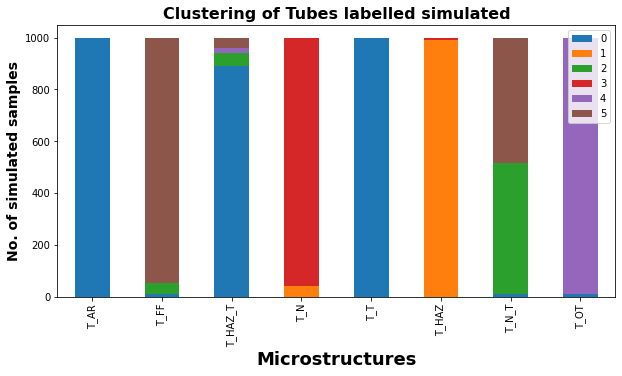

In [82]:
bar_chart('labels')

In [85]:
def bar_chart_unknown(feature):
    sample_1=labeled_df_tube[labeled_df_tube['sample']=='T_B1'][feature].value_counts()
    sample_2=labeled_df_tube[labeled_df_tube['sample']=='T_B2'][feature].value_counts()
    sample_3=labeled_df_tube[labeled_df_tube['sample']=='T_B3'][feature].value_counts()
    sample_4=labeled_df_tube[labeled_df_tube['sample']=='T_B4'][feature].value_counts()
    sample_5=labeled_df_tube[labeled_df_tube['sample']=='T_B5'][feature].value_counts()
    sample_6=labeled_df_tube[labeled_df_tube['sample']=='T_B6'][feature].value_counts()
    sample_7=labeled_df_tube[labeled_df_tube['sample']=='T_B7'][feature].value_counts()
    sample_8=labeled_df_tube[labeled_df_tube['sample']=='T_B8'][feature].value_counts()
    df=pd.DataFrame([sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8])
    df.index=['T_B1','T_B2','T_B3','T_B4','T_B5','T_B6','T_B7','T_B8']
    df.plot(kind='bar',stacked=True,figsize=(10,5))
    plt.xlabel("Microstructures",fontsize=18, fontweight='bold')
    plt.ylabel("No. of simulated samples",fontsize=14, fontweight='bold')
    plt.title ("Clustering of Tubes Blind simulated",fontsize=16, fontweight='bold')
    plt.show()

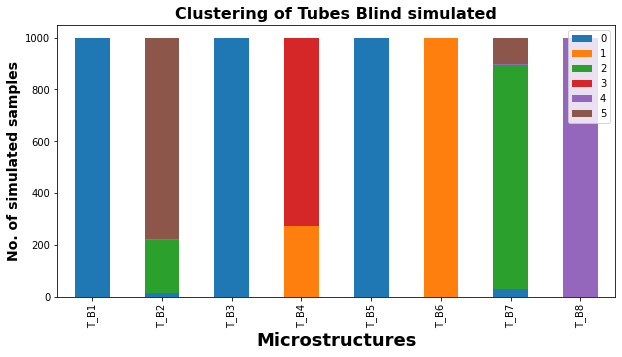

In [86]:
bar_chart_unknown('labels')